In [1]:
import pyvisa
import numpy as np
import sys
import binascii
import os
import time
import codecs
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline
class Inst:

    def __init__(self):
    #hardcoded in AWG id number for now
        rm = pyvisa.ResourceManager()
        rm.list_resources()
        my_instrument = rm.open_resource('TCPIP0::140.247.189.152::inst0::INSTR')
        self.instrument = my_instrument


    def initialize(self):
        instrument=self.instrument
        instrument.write('*IDN?')
        return instrument.read()
    
    def prepareforsequenceloading(self):
        instrument=self.instrument
        instrument.write('WLIS:WAV:DEL ALL')
        frequency = 100000000
        instrument.write('SOUR:FREQ {frequency}'.format(frequency=frequency))
        print('SOUR:FREQ {frequency}'.format(frequency=frequency))
        instrument.write('*OPC?')
        print(instrument.read())
        ratein=50*10**9
        instrument.write('CLOCK:SRATE {rate}'.format(rate=ratein))
        instrument.write('CLOCK:SRATE?')
        out=instrument.read()
        print(out)
        instrument.write('SOUR:FREQ?')
        out = instrument.read()
        return out

    def importwaveformfromrawdata(self,waveform_name,waveform):
    
        size = 1024
        instrument=self.instrument
        instrument.write('WLIS:WAV:NEW "{name}", {size}'.format(name=waveform_name,size=size))
        instrument.write('SYST:ERR?')
        print(instrument.read())
    
        #instrument.write('WLIS:WAV:DATA "{name}",0,{sizef},#44096{waveform}'.format(name=waveform_name, 
        #                                                                            sizef = size, waveform=waveform))
    
        #instrument.write_binary_values('WLIS:WAV:DATA "Test1",0,{sizef},#44096'.format(sizef= size), waveform)

        instrument.write_binary_values('WLIS:WAV:DATA "Test2",0,', waveform)
    
        #Test raw labveiw input:
        #instrument.write(visaWrite)
    
        #print('WLIS:WAV:DAT "{name}",0,{size},#72001600{waveform}'.format(name=waveform_name, size=size, waveform = waveform))
        #WLIST:WAVEFORM:DATA "TestWfm",0,1024,#44096
    
        instrument.write('*OPC?')
        print(instrument.read())
        instrument.write('SYST:ERR?')
        print(instrument.read())
        #:A "%s",0,%d,#%d%d%s;
        #:WLIS:WAV:MARK:DATA "%s",0,%d,#%d%d%s;
    
        return
    
    def importwaveformfromrawdata(self,waveform_name,waveform):
        instrument=self.instrument
        size = len(waveform)
    
        #Define a new waveform
        instrument.write('WLIS:WAV:NEW "{name}", {size}'.format(name=waveform_name,size=size))
    
        #instrument.write('SYST:ERR?')
        #print(instrument.read())

        #Load data to waveform
        instrument.write_binary_values('WLIS:WAV:DATA "{name}",0,'.format(name = waveform_name), waveform.tolist())  

        instrument.write('SYST:ERR?')

        return instrument.read()


    def loadwaveforms(self,names,waveforms):
        instrument=self.instrument
        #Delete previous waveforms
        instrument.write('WLIS:WAV:DEL ALL')
        instrument.write('SLIS:SEQ:DEL ALL')
    
        #Load list of waveforms
        for i in np.arange(np.size(names)):
            importwaveformfromrawdata(instrument,names[i],waveforms[i])
        
        instrument.write('SYST:ERR?')
        return instrument.read()


    def loadsinglewaveform(self,names,waveforms):
        instrument=self.instrument
        instrument.write("WLIS:LIST?")
        out = instrument.read()
        out=','+out[1:-2]+','
        if out.find(','+names+',')>-1:
            instrument.write('WLIS: DEL '+names)
        instrument.write('WLIS:WAV:DEL "'+str(names)+'"')
        #Load list of waveforms

        self.importwaveformfromrawdata(names,waveforms)
        
        instrument.write('SYST:ERR?')
        return instrument.read()

    def configuresequenceinchunks(self,sequence_name,element_names,wait_triggers,
                              flagsA,flagsB,flagsC,flagsD,repeats,jump_triggers,gotos,jump_steps):
        instrument=self.instrument
        step_num = np.size(element_names)
    
        #Delete old sequences
        instrument.write('SLIS:SEQ:DEL ALL')
    
        #Add a new sequence
        instrument.write('SLIS:SEQ:NEW  "{name}", {size}'.format(name=sequence_name,size=step_num))
    
        #Whether jump happens immediately or at end of step, default = end
        instrument.write('SLIS:SEQ:EVEN:JTIM "{name}", END'.format(name=sequence_name))
    
        #Whether flags toggle on repeat, default = off
        instrument.write('SLIS:SEQ:RFL "{name}", OFF'.format(name=sequence_name))
    
    
        for step in np.arange(step_num):
        
            #Add a step for each wavform
            waveform = element_names[step]
            instrument.write('SLIS:SEQ:STEP{step}:TASS1:WAV "{sequence}", "{waveform}"'.format(step=step+1,sequence=sequence_name,waveform = waveform))
    
            #Whether to wait for A or B trigger, default = off
            wtrigger = wait_triggers[step] #'ATR','BTR','OFF'
            instrument.write('SLIS:SEQ:STEP{step}:WINP "{sequence}",{trigger}'.format(step=step+1,sequence=sequence_name,trigger=wtrigger))
    
            #Set flags
            flagA = flagsA[step] #HIGH,LOW,PULSE,TOGG,NCH
            flagB = flagsB[step]
            flagC = flagsC[step]
            flagD = flagsD[step]
            instrument.write('SLIS:SEQ:STEP{step}:TFL1:AFL "{sequence}",{flag}'.format(step=step+1,sequence=sequence_name,flag=flagA))
            instrument.write('SLIS:SEQ:STEP{step}:TFL1:BFL "{sequence}",{flag}'.format(step=step+1,sequence=sequence_name,flag=flagB))
            instrument.write('SLIS:SEQ:STEP{step}:TFL1:CFL "{sequence}",{flag}'.format(step=step+1,sequence=sequence_name,flag=flagC))
            instrument.write('SLIS:SEQ:STEP{step}:TFL1:DFL "{sequence}",{flag}'.format(step=step+1,sequence=sequence_name,flag=flagD))
    
            #Set repeat count
            repeat = repeats[step] #'INF','ONCE'
            instrument.write('SLIS:SEQ:STEP{step}:RCO "{sequence}",{repeat}'.format(step=step+1,sequence=sequence_name,repeat=repeat))
    
            #Whether to jump on A or B trigger, default = off
            jtrigger = jump_triggers[step] #'ATR','BTR','OFF'
            instrument.write('SLIS:SEQ:STEP{step}:EJIN "{sequence}",{trigger}'.format(step=step+1,sequence=sequence_name,trigger=jtrigger))
    
            #Sets Goto
            goto = gotos[step] #'NEXT','FIRS','LAST','END',#
            instrument.write('SLIS:SEQ:STEP{step}:GOTO "{sequence}",{goto}'.format(step=step+1,sequence=sequence_name,goto=goto))
    
            #sets step to jump to
            jumpto = jump_steps[step] #'NEXT','FIRS','LAST','END',#
            instrument.write('SLIS:SEQ:STEP{step}:EJUM "{sequence}",{jumpto}'.format(step=step+1,sequence=sequence_name,jumpto=jumpto))

        return

    def load_seq_csv(self,file):
    
        seq_table = np.loadtxt(file,dtype='str',skiprows=1,delimiter=',',encoding='utf8')

        step_names = seq_table[:,1]

        wait_triggers  = ['OFF']*np.size(step_names)

        jump_triggers = seq_table[:,7]

        jump_steps = seq_table[:,8]

        gotos = seq_table[:,9]

        repeats = seq_table[:,6]

        event_jumps = np.zeros_like(step_names)

        flagsA = seq_table[:,2]
        flagsB = seq_table[:,3]
        flagsC = seq_table[:,4]
        flagsD = seq_table[:,5]

        return [step_names,wait_triggers,flagsA,flagsB,flagsC,flagsD,repeats,jump_triggers,gotos,jump_steps]
    
    def generateDJtable(self, seqname, pattern,step):
        instrument=self.instrument
        #Check number of steps
        instrument.write('SLIST:SEQUENCE:LENGTH? "{seq}"'.format(seq=seqname))
        a = instrument.read()
        print(a)
        steps = int(a) 
    
    
        #Deleted two commas after JSTROBE and SEDG (One Each) Formerly
        #instrument.write('AWGCONTROL:PJUMP:JSTROBE, ON')
        #instrument.write('AWGC:PJUM:SEDG, RIS')
        #Turn strobe jump on, regardless of address pattern change
        instrument.write('AWGCONTROL:PJUMP:JSTROBE ON')
    
        #Trigger on rising strobe
        instrument.write('AWGC:PJUM:SEDG RIS')

        #Enable pattern jump for current sequence
        instrument.write('SLIS:SEQ:EVEN:PJUM:ENAB "{seq}", ON'.format(seq=seqname))

        #If only one pattern jump, convert to array
        if np.size(step) == 1:
            step=[step]
            pattern=[pattern]
    
        #Iterate through requested pattern jumps and write only if they point to an existing step
        for i, stepE in enumerate(step):
            patternE=pattern[i]
            if stepE < steps+1:
                instrument.write('SLIS:SEQ:EVEN:PJUM:DEF "{seq}", {pat}, {stp}'.format(seq=seqname,pat=patternE,stp=int(stepE)))

        return

    def assignsequence(self,seqname):
        instrument=self.instrument
        instrument.write('CASS:SEQ "{seqname}", 1'.format(seqname=seqname))
        time.sleep(3)
        instrument.write('*OPC?')
        print(instrument.read())
    
        return

    def configureNewSequence(self,sequence_name,step_num):
        instrument=self.instrument
        #Delete old sequences
        instrument.write('SLIS:SEQ:DEL ALL')
    
        #Add a new sequence
        instrument.write('SLIS:SEQ:NEW  "{name}", {size}'.format(name=sequence_name,size=step_num))
        
        #Whether jump happens immediately or at end of step, default = end
        instrument.write('SLIS:SEQ:EVEN:JTIM "{name}", END'.format(name=sequence_name))
        
        #Whether flags toggle on repeat, default = off
        instrument.write('SLIS:SEQ:RFL "{name}", OFF'.format(name=sequence_name))
        
        return

    def addSeqElements(self,sequence_name,element_names,wait_triggers,
                                flagsA,flagsB,flagsC,flagsD,repeats,jump_triggers,gotos,jump_steps,stepTar=None):
        instrument=self.instrument
        step_num = np.size(jump_steps)
        if step_num==1:
            if stepTar==None:
                undsc=element_names.find('_')
                stepTar=int(element_names[0:int(undsc)])
            step=stepTar
            #Add a step for each wavform
            waveform = element_names
            instrument.write('SLIS:SEQ:STEP{step}:TASS1:WAV "{sequence}", "{waveform}"'.format(step=step+1,sequence=sequence_name,waveform = waveform))
        
            #Whether to wait for A or B trigger, default = off
            wtrigger = wait_triggers #'ATR','BTR','OFF'
            instrument.write('SLIS:SEQ:STEP{step}:WINP "{sequence}",{trigger}'.format(step=step+1,sequence=sequence_name,trigger=wtrigger))
        
            #Set flags
            flagA = flagsA #HIGH,LOW,PULSE,TOGG,NCH
            flagB = flagsB
            flagC = flagsC
            flagD = flagsD
            instrument.write('SLIS:SEQ:STEP{step}:TFL1:AFL "{sequence}",{flag}'.format(step=step+1,sequence=sequence_name,flag=flagA))
            instrument.write('SLIS:SEQ:STEP{step}:TFL1:BFL "{sequence}",{flag}'.format(step=step+1,sequence=sequence_name,flag=flagB))
            instrument.write('SLIS:SEQ:STEP{step}:TFL1:CFL "{sequence}",{flag}'.format(step=step+1,sequence=sequence_name,flag=flagC))
            instrument.write('SLIS:SEQ:STEP{step}:TFL1:DFL "{sequence}",{flag}'.format(step=step+1,sequence=sequence_name,flag=flagD))
        
            #Set repeat count
            repeat = repeats #'INF','ONCE'
            instrument.write('SLIS:SEQ:STEP{step}:RCO "{sequence}",{repeat}'.format(step=step+1,sequence=sequence_name,repeat=repeat))
        
            #Whether to jump on A or B trigger, default = off
            jtrigger = jump_triggers #'ATR','BTR','OFF'
            instrument.write('SLIS:SEQ:STEP{step}:EJIN "{sequence}",{trigger}'.format(step=step+1,sequence=sequence_name,trigger=jtrigger))
        
            #Sets Goto
            goto = gotos #'NEXT','FIRS','LAST','END',#
            instrument.write('SLIS:SEQ:STEP{step}:GOTO "{sequence}",{goto}'.format(step=step+1,sequence=sequence_name,goto=goto))
        
            #sets step to jump to
            jumpto = jump_steps #'NEXT','FIRS','LAST','END',#
            instrument.write('SLIS:SEQ:STEP{step}:EJUM "{sequence}",{jumpto}'.format(step=step+1,sequence=sequence_name,jumpto=jumpto))
        else:
            for step in np.arange(step_num):
            
                #Add a step for each wavform
                waveform = element_names[step]
                instrument.write('SLIS:SEQ:STEP{step}:TASS1:WAV "{sequence}", "{waveform}"'.format(step=step+1,sequence=sequence_name,waveform = waveform))
        
                #Whether to wait for A or B trigger, default = off
                wtrigger = wait_triggers[step] #'ATR','BTR','OFF'
                instrument.write('SLIS:SEQ:STEP{step}:WINP "{sequence}",{trigger}'.format(step=step+1,sequence=sequence_name,trigger=wtrigger))
        
                #Set flags
                flagA = flagsA[step] #HIGH,LOW,PULSE,TOGG,NCH
                flagB = flagsB[step]
                flagC = flagsC[step]
                flagD = flagsD[step]
                instrument.write('SLIS:SEQ:STEP{step}:TFL1:AFL "{sequence}",{flag}'.format(step=step+1,sequence=sequence_name,flag=flagA))
                instrument.write('SLIS:SEQ:STEP{step}:TFL1:BFL "{sequence}",{flag}'.format(step=step+1,sequence=sequence_name,flag=flagB))
                instrument.write('SLIS:SEQ:STEP{step}:TFL1:CFL "{sequence}",{flag}'.format(step=step+1,sequence=sequence_name,flag=flagC))
                instrument.write('SLIS:SEQ:STEP{step}:TFL1:DFL "{sequence}",{flag}'.format(step=step+1,sequence=sequence_name,flag=flagD))
        
                #Set repeat count
                repeat = repeats[step] #'INF','ONCE'
                instrument.write('SLIS:SEQ:STEP{step}:RCO "{sequence}",{repeat}'.format(step=step+1,sequence=sequence_name,repeat=repeat))
        
                #Whether to jump on A or B trigger, default = off
                jtrigger = jump_triggers[step] #'ATR','BTR','OFF'
                instrument.write('SLIS:SEQ:STEP{step}:EJIN "{sequence}",{trigger}'.format(step=step+1,sequence=sequence_name,trigger=jtrigger))
        
                #Sets Goto
                goto = gotos[step] #'NEXT','FIRS','LAST','END',#
                instrument.write('SLIS:SEQ:STEP{step}:GOTO "{sequence}",{goto}'.format(step=step+1,sequence=sequence_name,goto=goto))
        
                #sets step to jump to
                jumpto = jump_steps[step] #'NEXT','FIRS','LAST','END',#
                instrument.write('SLIS:SEQ:STEP{step}:EJUM "{sequence}",{jumpto}'.format(step=step+1,sequence=sequence_name,jumpto=jumpto))

        return    

In [2]:
import numpy as np
import matplotlib.pyplot as plt
#import inst as inst


#Input variables
samplingRate=50*10**9 #Sampling rate of AWG
maxReps=255 #Max repititions of a sequence element, used for smart wait

#Define Phase Class
class Phase:
    def __init__(self, freq, ampli, angle):
        self.freq = freq
        self.amp = ampli
        self.angle = angle
        
     #equality overwrite
    def __eq__(self,other):
        if type(self)!=type(other):
            return False
        if int(self.freq)==int(other.freq):
            if int(self.amp*10000)==int(other.amp*10000):
                if int(self.angle*100)==int(other.angle*100):
                    return True
        return False
    
    def __ne__(self,other):
        return not self==other
        
#Define Phase Tracking Class used for phase stability within chunk
#Pass prevChunk to make phase stable between chunks as well
class PhaseTrack:
    
    #phase to track and start time in points
    def __init__(self, phase, start,prevChunk=None):
        self.phase=phase
        self.start=start #in points
        self.prevAngle=0
        if not prevChunk is None:
            if not prevChunk.getPhaseTrack(phase) is None:
                prevChunkreps=1 #takes into account repititions of a chunk when setting phase
                if not prevChunk.meta.reps == 'ONCE':
                    prevChunkreps=prevChunk.meta.reps
                prevTrack=prevChunk.getPhaseTrack(phase)
                self.prevAngle=prevTrack.getAngle(prevChunk.getDurationGroomed()*prevChunkreps)
        
    #get angle a certain number of points into the chunk
    #does not include the angle of the phase object itself
    def getAngle(self, t):
        freq=self.phase.freq
        return ((360)*(t-self.start)*freq/samplingRate)%360+self.prevAngle
    
    #Check exact phase including angle and amplitude
    def hasPhase(self, phase):
        return phase==self.phase
    
    #check only frequency
    def hasFreq(self,phase):
        return self.phase.freq==phase.freq
    
#Define Data structure that carries all metadata for a chunk
#Name, reps, id, next,jump  next, flags, trigger
class MetaChunk:
    def __init__(self,idNum,name=None,nextNum=None,flags=None,reps=None,jumpNum=None,trigger=None):
        if name is None:
            name=str(idNum)
        if nextNum is None:
            nextNum=0
        if flags is None:
            flags=['LOW','LOW','LOW','LOW']
        if reps is None:
            reps='ONCE'
        if jumpNum is None:
            jumpNum=0
        if trigger is None:
            trigger='OFF'
        
        self.idNum=idNum
        self.name=name
        self.nextNum=nextNum+1
        self.flags=flags
        self.reps=reps
        self.jumpNum=jumpNum+1
        self.trigger=trigger

    
#Define Chunk Class
#phase takes a Phase object 
#dur: duration in ns 
#off: wait time at the start of the pulse in ns
#reps: times chunk is repeated
#idNum: target ID number in AWG
#nextNum: next sequence element to run after pulse is completed
#jumpNum: next sequence element to run after pulse is completed if jump is activated
class Chunk:
    
    def __init__(self, phase, dur, off,meta, prevChunk=None):
        self.meta=meta
        self.groomedOutputs=[]
        self.trackedPhases=[]
        self.outputs=[]
        self.prevChunk=prevChunk
        #loads all the tracked phases from prev Chunk into the new chunk
        if not prevChunk is None:
            if not prevChunk.trackedPhases is None:
                for trPh in prevChunk.trackedPhases:
                    newTrPh=PhaseTrack(trPh.phase,0,prevChunk)
                    self.trackedPhases.append(newTrPh)
        waveOC=[]    
        #if only one set of inputs not stored in an array make it an array
        if np.size(off)==1:
            if type(off) is float or type(off) is int:
                dur=[dur]
                phase=[phase]
                off=[off]
 
        # once inputs are in an array       
       
        for i,ph in enumerate(phase): #go through list of inputs
                
            #code to calculate the extra phase required for phase coherence for a given frequency within a chunk
            offLength=round(off[i]*samplingRate/10**9)
            prevAngle=0
            hasPhase=0
                
            #Does a phase track exist for this phase?
            if np.size(self.trackedPhases)>0:
                    
                for tPh in self.trackedPhases:
                    if tPh.hasFreq(ph): #if yes grab the old angle
                        hasPhase=1
                        prevAngle=prevAngle+tPh.getAngle(np.size(self.outputs)+offLength)
            if hasPhase==0: #if no generate a new copy of the phase and append it
                newPT=PhaseTrack(ph,np.size(self.outputs)+offLength,self.prevChunk)
                self.trackedPhases.append(newPT)
                prevAngle=newPT.getAngle(np.size(self.outputs)+offLength)
                    
            #generate sin with the correct phase and add to outputs
            waveT=np.linspace(0,round(dur[i]*samplingRate/10**9)-1,round(dur[i]*samplingRate/10**9))
            waveO=ph.amp*np.sin(2*np.pi*(waveT*ph.freq/samplingRate+(ph.angle+prevAngle)/360))
            if off[i]>0:
                offO=np.zeros(offLength)
                waveOC = np.concatenate((waveOC,offO,waveO))
                self.outputs=waveOC
            else:
                waveOC = np.concatenate((waveOC,waveO))
                self.outputs=waveOC
        self.groomChunk(0) #groom after every change
            
            
        
    def appendPulse(self, phase, dur, off):
        
        #if only one set of inputs and not stored in an array make it an array

        
        waveOC=[]

        if np.size(off)==1:
            if type(off) is float or type(off) is int:
                dur=[dur]
                phase=[phase]
                off=[off]
        for i,ph in enumerate(phase):
                               
            #code to calculate the extra phase required for phase coherence for a given frequency within a chunk
            offLength=round(off[i]*samplingRate/10**9)
            prevAngle=0
            hasPhase=0
                
            if np.size(self.trackedPhases)>0:
                    
                for tPh in self.trackedPhases:
                        
                    if tPh.hasFreq(ph):
                            
                        hasPhase=1
                        prevAngle=prevAngle+tPh.getAngle(np.size(self.outputs)+offLength)
            if hasPhase==0:
                newPT=PhaseTrack(ph,np.size(self.outputs)+offLength,self.prevChunk)
                self.trackedPhases.append(newPT)
                prevAngle=newPT.getAngle(np.size(self.outputs)+offLength)
            waveT=np.linspace(0,round(dur[i]*samplingRate/10**9)-1,round(dur[i]*samplingRate/10**9))
            waveO=ph.amp*np.sin(2*np.pi*(waveT*ph.freq/samplingRate+(ph.angle+prevAngle)/360))
            if off[i]>0:
                offO=np.zeros(round(off[i]*samplingRate/10**9))
                waveOC = np.concatenate((offO,waveO))
                self.outputs=np.concatenate((self.outputs,waveOC))
            else:
                waveOC = waveO
                self.outputs=np.concatenate((self.outputs,waveOC))
        self.groomChunk(0)  
            
    #Returns duration in points        
    def getDuration(self):
        return np.size(self.outputs)
    
    #Returns duration in points        
    def getDurationGroomed(self):
        return np.size(self.groomedOutputs)
    
    #Grooms Chunk in accordance with Groom Waveforms VI 
    #Rules:  
    #1) Add 0s corresponding to Channel Delay (ns) to beginning of Chunk
    #2) Add 0s to end of Chunk corresponding to difference between max delay and Ch Delay
    #3) Add 0s to end of Chunk to ensure that Chunk is mimumum of 4800 points and is a multiple of 240 points
    def groomChunk(self, chDelay=0, maxDelay=None):
        minSize=4800
        mult=240
        if maxDelay is None:
            maxDelay = chDelay
        chDelayOutput = np.zeros(int(chDelay*samplingRate/10**9))
        extraDelayOutput = np.zeros(int((maxDelay-chDelay)*samplingRate/10**9))
        testOutput = np.concatenate((chDelayOutput,self.outputs,extraDelayOutput))
        if np.size(testOutput)%mult > 0:
            multSup = np.zeros(240-np.size(testOutput)%mult)
            testOutput = np.concatenate((testOutput,multSup))
        
        if np.size(testOutput) < minSize:
            sizeSup=np.zeros(minSize-np.size(testOutput))
            testOutput = np.concatenate((testOutput,sizeSup))
            
        self.groomedOutputs=testOutput
    
    #looks for and returns phaseTrack assosciated with the frequency of the given phase if it exists
    def getPhaseTrack(self, phase):
        for tPh in self.trackedPhases:
            if tPh.hasFreq(phase):
                return tPh
        return None
        
    
class Sequence:
    def __init__(self):
        self.chunkList=[]
        
    def overwriteChunk(self, phase, dur, off,meta,prevChunk):
        idNum=meta.idNum
        if idNum < self.getNextID():
            self.chunkList[idNum] = Chunk(phase, dur, off,meta,prevChunk)
            return self.getC(idNum)
        else:
            print("Warning: attempted to overwrite sequence at too high an id number")
            print("Chunk appended at ID number " + str(self.getNextID()))
            meta.idNum=self.getNextID()
            self.appendChunk(phase, dur, off,meta,prevChunk)
            return self.getC(idNum)
        
            
    def appendChunk(self, phase, dur, off,meta=None,prevChunk=None):
        if meta is None:
            meta=MetaChunk(self.getNextID())
        self.chunkList.append(Chunk(phase, dur, off,meta,prevChunk))
        return self.chunkList[meta.idNum]
        
    # generates conditional xy8-N for N given by reps and adds it to the queue as a single chunk
    # FinalPi is -1,0,1. If 1 uses phase1, if 0 deletes final pi, if -1 inverts the direction of the final pi/2
    def appendXY8(self, phase1, phase2, pi1, pi2, tau, num, meta=None, firstPi=None, finalPi=None, prevChunk=None):
        if finalPi is None:
            finalPi=0
        if firstPi is None:
            firstPi=0
        if meta is None:
            meta=MetaChunk(self.getNextID())
            
        if firstPi==1 :
            xyChunk=self.appendChunk(phase1,pi1/2,0,meta, prevChunk)
        else:
            xyChunk=self.appendChunk(phase1,0,0,meta,prevChunk)
        
        N=np.linspace(1,num,num)
        for n in N:
            xyChunk.appendPulse(phase1, pi1, tau/2-pi1/2)
            xyChunk.appendPulse(phase2, pi2, tau-pi1/2-pi2/2)
            xyChunk.appendPulse(phase1, pi1, tau-pi1/2-pi2/2)
            xyChunk.appendPulse(phase2, pi2, tau-pi1/2-pi2/2)
            xyChunk.appendPulse(phase2, pi2, tau-pi2/2-pi2/2)
            xyChunk.appendPulse(phase1, pi1, tau-pi1/2-pi2/2)
            xyChunk.appendPulse(phase2, pi2, tau-pi1/2-pi2/2)
            xyChunk.appendPulse(phase1, pi1, tau-pi1/2-pi2/2)
            #last wait segment
            xyChunk.appendPulse(phase1, 0, tau/2-pi1/2)
        if finalPi == 1:
            xyChunk.appendPulse(phase1,pi1/2,0)
        if finalPi == -1:
            xyChunk.appendPulse(Phase(phase1.freq,phase1.amp,phase1.angle+180),pi1/2,0)
        return xyChunk
    
    # generates unconditional xy8-N for N given by reps and adds it to the queue as a single chunk
    # FinalPi is -1,0,1. If 1 uses phase1, if 0 deletes final pi, if -1 inverts the direction of the final pi/2
    def appendUXY8(self, phase1X, phase1Y, phase2X, phase2Y, pi1, pi2, tau, num, meta=None, finalPi=None, prevChunk=None):
        if finalPi is None:
            finalPi=1
        if meta is None:
            meta=MetaChunk(self.getNextID())
        xyChunk=self.appendChunk(phase1X,pi1/2,0,meta, prevChunk)
        xyChunk.appendPulse(phase2X,pi2/2,0)
        
        combPi=pi1+pi2
        N=np.linspace(1,num,num)
        for n in N:
            xyChunk.appendPulse(phase1X, pi1, tau/2-combPi/2)
            xyChunk.appendPulse(phase2X, pi2, 0)
            
            xyChunk.appendPulse(phase1Y, pi1, tau-combPi)
            xyChunk.appendPulse(phase2Y, pi2, 0)
            
            xyChunk.appendPulse(phase1X, pi1, tau-combPi)
            xyChunk.appendPulse(phase2X, pi2, 0)
            
            xyChunk.appendPulse(phase1Y, pi1, tau-combPi)
            xyChunk.appendPulse(phase2Y, pi2, 0)
            
            xyChunk.appendPulse(phase1Y, pi1, tau-combPi)
            xyChunk.appendPulse(phase2Y, pi2, 0)
            
            xyChunk.appendPulse(phase1X, pi1, tau-combPi)
            xyChunk.appendPulse(phase2X, pi2, 0)
            
            xyChunk.appendPulse(phase1Y, pi1, tau-combPi)
            xyChunk.appendPulse(phase2Y, pi2, 0)
            
            xyChunk.appendPulse(phase1X, pi1, tau-combPi)
            xyChunk.appendPulse(phase2X, pi2, 0)
            #last wait segment
            xyChunk.appendPulse(phase1X, 0, tau/2-combPi/2)
        if finalPi == 1:
            xyChunk.appendPulse(phase1X,pi1/2,0)
            xyChunk.appendPulse(phase2X,pi2/2,0)
        if finalPi == -1:
            xyChunk.appendPulse(Phase(phase1X.freq,phase1X.amp,phase1X.angle+180),pi1/2,0)
            xyChunk.appendPulse(Phase(phase2X.freq,phase2X.amp,phase2X.angle+180),pi2/2,0)
        return xyChunk
    
    
    # Unconditional Pi Echo with optional RF pulses between every second pi pulse
    # phase 1 and 2 are electron phases for unconditional pi
    # dur RF is the duration of the RF pulse. Will be shortened to fit within the tau window if too long
    def appendUnEchoNPi(self, phase1, phase2, phaseRF, pi1, pi2, durRF, tau, num, meta=None, prevChunk=None):
        if meta is None:
            meta=MetaChunk(self.getNextID())
        
        if durRF > tau - pi1/2 - pi2/2:
            durRF = tau - pi1/2 - pi2/2
         
        tauRed=(tau-durRF-pi1/2-pi2/2)/2
        #generate first echo component
        echoChunk=self.appendChunk(phase1,pi1,0,meta, prevChunk)
        echoChunk.appendPulse(phase2,pi2,0)
        echoChunk.appendPulse(phaseRF,durRF,tauRed)
        echoChunk.appendPulse(phase1,pi1,tauRed)
        echoChunk.appendPulse(phase2,pi2,0)
        echoChunk.appendPulse(phase1,0,tau-pi1/2-pi2/2)
        
        if num > 1:
            N=np.linspace(1,num-1,num-1)
            for n in N:
                echoChunk.appendPulse(phase1,pi1,0)
                echoChunk.appendPulse(phase2,pi2,0)
                echoChunk.appendPulse(phaseRF,durRF,tauRed)
                echoChunk.appendPulse(phase1,pi1,tauRed)
                echoChunk.appendPulse(phase2,pi2,0)
                echoChunk.appendPulse(phase1,0,tau-pi1/2-pi2/2)
                
        return echoChunk
        
        
    
    # 3 CPis, Electron, Nuclear, Electron with off in between them
    def appendSwap(self, phase1, phase2, pi1, pi2, off, meta=None, prevChunk=None):
        if meta is None:
            meta=MetaChunk(self.getNextID())
        swapChunk=self.appendChunk(phase1,pi1,off,meta,prevChunk)
        swapChunk.appendPulse(phase2, pi2, off)
        swapChunk.appendPulse(phase1, pi1, off)
        return swapChunk
    
    def appendWait(self,dur,meta=None, prevChunk=None):
        if meta is None:
            meta=MetaChunk(self.getNextID())
        waitChunk=self.appendChunk(Phase(1,1,1),0,dur, meta, prevChunk)
        
        return waitChunk
    
    #Find the optimal duration/repition combination for a given wait duration, ns error tolerance, and maxReps
    #Then append this "smart" wait to the sequence
    def appendSmartWait(self,dur,tol,meta=None,prevChunk=None):
        if meta is None:
            meta=MetaChunk(self.getNextID())
        
        repList=np.linspace(1,maxReps,maxReps)
        error=abs(np.round(dur/repList)*repList-dur)
        repList=np.where(error<tol,repList,0)
        reps=int(np.max(repList))
        meta.reps=reps
        
        smChunk=self.appendChunk(Phase(1,1,1),0, int(dur/maxReps), meta, prevChunk)
        
        return smChunk
    
    #Print a table of the current chunks
    def tabulate(self):
        elements=np.linspace(0,np.size(self.chunkList)-1,np.size(self.chunkList))
        print('Name     Dur    DurGroom   Reps     Next     Jump')
        print('__________________________________________________')
        for i in elements:
            i=int(i)  
            print(self.getC(i).meta.name + '       ' + str(self.getC(i).getDuration()) + '     ' + str(self.getC(i).getDurationGroomed()) + '     ' 
                  + str(self.getC(i).meta.reps)+ '       ' + str(self.getC(i).meta.nextNum)+ '        ' + str(self.chunkList[i].meta.jumpNum))
    
    #Get a chunk from the list                                                                                  
    def getC(self,n):
        for ch in self.chunkList:
            if ch.meta.idNum==n:
                return ch
    
    #Plot a chunk from the list
    def plotChunk(self,n):
        plt.plot(np.linspace(0,np.size(self.getC(n).outputs)-1,np.size(self.getC(n).outputs)),self.getC(n).outputs)
        return self.getC(n)
    
    #Plot a groomed chunk from the list
    def plotGroomedChunk(self,n):
        
        gp=plt.plot(np.linspace(0,np.size(self.getC(n).groomedOutputs)-1,np.size(self.getC(n).groomedOutputs)),self.getC(n).groomedOutputs)
        return gp
    
    #Applies grooming procedure to all chunks- call as part of the loading sequence
    def groomAll(self, chDelay, maxDelay=None):
        if maxDelay is None:
            maxDelay = chDelay
        for ch in self.chunkList:
            ch.groomChunk(chDelay, maxDelay)
            
    def getNextID(self):
        return np.size(self.chunkList)
    
    #load sequence into instrument- should be a inst object as defined in inst.py
    #If not run in notebook form this may need to be modified to indicate where the AWG interface commands are
    def loadSequence(self,instrument,seqName=None):
        if seqName is None:
            seqName='ExpSequence'
        self.groomAll(0)
        print(np.size(self.chunkList))
        instrument.configureNewSequence(seqName,np.size(self.chunkList))
        for ch in self.chunkList:
            name=str(ch.meta.idNum)+'_'+str(ch.meta.name)
            instrument.loadsinglewaveform(name,ch.groomedOutputs)
            meta=ch.meta
            instrument.addSeqElements(seqName,name,'OFF',
                              meta.flags[0],meta.flags[1],meta.flags[2],meta.flags[3]
                           ,meta.reps,meta.trigger,meta.nextNum,meta.jumpNum)
            
            

In [43]:
#import AWG 
import numpy as np
#import inst 

#This is all test Sequence stuff- not for actual experiment.


#instbox=Inst()
#my_instrument=instbox.instrument

expSeq=Sequence()

#Generate Test Version of Experimental Sequence
xENUPhase=Phase(12*10**9,1,0)
yENUPhase=Phase(12*10**9,1,90)
piENU=25


xENDPhase=Phase(12.1*10**9,1,0)
yENDPhase=Phase(12.1*10**9,1,90)
piEND=35

xNEDPhase=Phase(22*10**6,1,0)
xNEUPhase=Phase(42*10**6,1,0)
PiNEU=1600
PiNED=2000

readoutWindow=500*10**1
readoutFlags=['HIGH','HIGH','HIGH','LOW']
offFlags=['LOW','LOW','LOW','LOW']
readoutTrig='ATR'

xy8Reps=4
xy8tau=100*10**1
xy8Phase_x=xENDPhase
xy8Phase_y=yENDPhase
xy8pi=piEND
xy8Flags=['LOW','HIGH','HIGH','HIGH']
xy8Trig='BTR'

decNTau=100000


#self, phase, dur, off,meta=None,prevChunk=None)
#IDNum,name=None,nextNum=None,flags=None,reps=None,jumpNum=None,trigger=None
#phase1, phase2, pi1, pi2, tau, num, meta=None, firstPi=None, finalPi=None, prevChunk=None


#Basic init nuc and electron without Swap
#Add initial readout, upi pulse if high readout and loop back, 
#cpi if low, followed by readout. if high continue to next step, if low UNPi, back to first step
readChunk=expSeq.appendWait(readoutWindow,MetaChunk(
    expSeq.getNextID(),'Readout1', expSeq.getNextID()+2,readoutFlags,1,expSeq.getNextID()+1,readoutTrig))
piChunk=expSeq.appendChunk([xENUPhase,xENDPhase],[piENU,piEND],[0,0],MetaChunk(expSeq.getNextID(),
    'InitUPi',readChunk.meta.idNum),readChunk)
cpiChunk=expSeq.appendChunk(xENUPhase,piENU,0,MetaChunk(expSeq.getNextID(),
    'InitCPi',expSeq.getNextID()+1),readChunk)
readChunk2=expSeq.appendWait(readoutWindow,MetaChunk(
    expSeq.getNextID(),'Readout2', expSeq.getNextID()+1,readoutFlags,1,expSeq.getNextID()+2,readoutTrig),cpiChunk)
npiChunk=expSeq.appendChunk([xNEDPhase,xNEUPhase],[PiNEU,PiNED],[0,0],MetaChunk(expSeq.getNextID(),
    'InitUNPi',readChunk.meta.idNum),readChunk2)

#Looping conditional XY8 that splits into either conditional pi/2 or swap + decoupling
#stops after current rep of XY8 if a count comes to trigger B
rootID=expSeq.getNextID()
xyChunks=[]

cpihalfChunk=expSeq.appendChunk(xy8Phase_x,piENU/2,96-piENU/2,MetaChunk(expSeq.getNextID(),
    'CPiHalf',expSeq.getNextID()+1),readChunk2)
prevChunk=cpihalfChunk

#add each independent xy8 chunk- must be seperate for phase coherence
# if xy8 isn't inherently multiple of 240 points long we have a phase error here. should recode to force adjustment to tau
#ie, end of xy8 won't bring pulse back exactly to where it started because of point padding at the end of the chunk
for i in np.arange(xy8Reps):
    xyChunk=expSeq.appendXY8(xy8Phase_x,xy8Phase_y,xy8pi,xy8pi,xy8tau,1,MetaChunk(expSeq.getNextID(),
                        'C_XY8',expSeq.getNextID()+1,xy8Flags,1,expSeq.getNextID()+xy8Reps+1,xy8Trig),0,0,prevChunk)
    prevChunk=xyChunk
    xyChunks.append(xyChunk)
expSeq.appendChunk(xy8Phase_x,piENU/2,0,MetaChunk(expSeq.getNextID(),'CPiHalf'),prevChunk)

swapChunks=[]
#add a Nuc Cpi for each XY8 sequence element- must be seperate for phase coherence
#these cpis aren't correct, need to have their values changed depending on XY8 tau choice
for i in np.arange(xy8Reps):
    swapChunk=expSeq.appendUnEchoNPi(xENUPhase, xENDPhase, xNEUPhase, piENU, piEND, PiNEU, xy8tau/2, 1
                , MetaChunk(expSeq.getNextID(),'NucCPi',expSeq.getNextID()+xy8Reps), xyChunks[i])
    swapChunks.append(swapChunk)

#Begin Nuclear Decoupling + Read + Electon XY8 sequence
#Note that the splits created to accomodate the XY8 reps before need to be maintained here for phase coherence

#modify wait time-readout-UpiRF to be multiple of 240
#break into small chunks up to max mults, add remainder in mutliples of 240 to extra chunk to round it off

#endPoints=[]
#for i in np.arange(xy8Reps):
    #add first wait
    #for number of readouts before dephase
        #add half read, UPiN, half read
        #for number of xy mults
            #add uxy8 and split off if count received, otherwise progress through
            #add each uxy8 chunk to endpoints list
        #only wait again if made it through sequence, make sure is multiple of 240, then break into pieces and append
#if it makes it to the end we never got a second photon, do pi/2 and start over
#for all elements of endpoints list
    #generate cpi and readout and append, then start over
    
 
    
    

#Dummy Chunk to end sequence
dummyChunk=expSeq.appendWait(1,MetaChunk(
    expSeq.getNextID(),'Dummy'))
dummyChunk=expSeq.appendWait(1,MetaChunk(
    expSeq.getNextID(),'Dummy'))
dummyChunk=expSeq.appendWait(1,MetaChunk(
    expSeq.getNextID(),'Dummy'))
dummyChunk=expSeq.appendWait(1,MetaChunk(
    expSeq.getNextID(),'DummyTest',0))

expSeq.tabulate()

#prevPulse=expSeq.appendUXY8(xENUPhase, yENUPhase, xENDPhase, yENDPhase, piENU, 
                       #piEND, 141, 1, MetaChunk(expSeq.getNextID(),'XY8_1'), 0)
#expSeq.appendChunk(xENUPhase,piENU/2,0,MetaChunk(expSeq.getNextID(),'PiHalf'),prevPulse)
#print(np.size(expSeq.chunkList))
#expSeq.loadSequence(instbox)

#This works- maybe last step is to write a generate metaData from CSV function, but the rest is done

Name     Dur    DurGroom   Reps     Next     Jump
__________________________________________________
Readout1       250000     250080     1       3        2
InitUPi       3000     4800     ONCE       1        1
InitCPi       1250     4800     ONCE       4        1
Readout2       250000     250080     1       5        6
InitUNPi       180000     180000     ONCE       1        1
CPiHalf       4800     4800     ONCE       7        1
C_XY8       400000     400080     1       8        12
C_XY8       400000     400080     1       9        13
C_XY8       400000     400080     1       10        14
C_XY8       400000     400080     1       11        15
CPiHalf       625     4800     ONCE       1        1
NucCPi       53000     53040     ONCE       16        1
NucCPi       53000     53040     ONCE       17        1
NucCPi       53000     53040     ONCE       18        1
NucCPi       53000     53040     ONCE       19        1
Dummy       50     4800     ONCE       1        1
Dummy       50     48

In [129]:
def genXY8Deer(seq,phase1, phase2, phaseD, pi1, pi2, piD, tau, num, meta=None, firstPi=None, finalPi=None, prevChunk=None):
    if finalPi is None:
        finalPi=0
    if firstPi is None:
        firstPi=1
    if meta is None:
        meta=MetaChunk(seq.getNextID())
            
    if firstPi==1 :
        xyChunk=seq.appendChunk(phase1,pi1/2,0,meta, prevChunk)
    elif firstPi==-1:
        xyChunk=seq.appendChunk(phase1,pi1/2,0,meta, prevChunk)
        xyChunk.appendPulse(phaseD, piD/2, 0)
    else:
        xyChunk=seq.appendChunk(phase1,0,0,meta,prevChunk)
            
    #start phase track for phaseD        
    xyChunk.appendPulse(phaseD,0,0)       
    N=np.linspace(1,num,num)
    for n in N:
        if firstPi==-1:
            xyChunk.appendPulse(phase1, pi1, tau-pi1/2-piD/2)
        else:
            xyChunk.appendPulse(phase1, pi1, tau-pi1/2)
        xyChunk.appendPulse(phaseD, piD,0)

        xyChunk.appendPulse(phase2, pi2, 2*tau-pi1/2-pi2/2-piD)
        xyChunk.appendPulse(phaseD, piD, 0)

        xyChunk.appendPulse(phase1, pi1, 2*tau-pi1/2-pi2/2-piD)
        xyChunk.appendPulse(phaseD, piD, 0)

        xyChunk.appendPulse(phase2, pi2, 2*tau-pi1/2-pi2/2-piD)
        xyChunk.appendPulse(phaseD, piD, 0)

        xyChunk.appendPulse(phase2, pi2, 2*tau-pi1/2-pi2/2-piD)
        xyChunk.appendPulse(phaseD, piD, 0)

        xyChunk.appendPulse(phase1, pi1, 2*tau-pi1/2-pi2/2-piD)
        xyChunk.appendPulse(phaseD, piD, 0)

        xyChunk.appendPulse(phase2, pi2, 2*tau-pi1/2-pi2/2-piD)
        xyChunk.appendPulse(phaseD, piD, 0)

        xyChunk.appendPulse(phase1, pi1, 2*tau-pi1/2-pi2/2-piD)
        xyChunk.appendPulse(phaseD, piD, 0)

        #last wait segment
        xyChunk.appendPulse(phase1, 0, tau-pi1/2-piD)
        #Add last pi half taking into account finalPi Angle
    xyChunk.appendPulse(Phase(phase1.freq,phase1.amp,phase1.angle+finalPi),pi1/2,0)
    return xyChunk

In [223]:
#This section contains scratch versions of all of the code parceled out below- in particular it was used to generate Deer XY8 sequences

expSeq=Sequence()

#Phase Information
SiVBFreq=12.637*10**9
SiVFFreq=11.791*10**9
#SiVFFreq2=11.97*10**9
AmpB=0.6 #Currently SiV 7
AmpF=0.3
SiVBPhaseX=Phase(SiVBFreq,AmpB,0)
SiVBPhaseY=Phase(SiVBFreq,AmpB,90)
SiVBPhaseMX=Phase(SiVBFreq,AmpB,180)
SiVFPhase=Phase(SiVFFreq,AmpF,0)
SiVFPhase2=Phase(SiVFFreq2,AmpF,0)
piB= 57
piF= 30

#Sequence Information
option=7#Choose what type of sequence to run
xy8Reps=4 #IE XY8-N N=xy8Reps
initFX=0 #1 if you want to init in x, otherwise 0 to init down by default
FinalPi=0 #angle of the final pi, 0 is x, 90 is y
SmartSeq=0; #1 if you want to smartSeq load. Will implement later.

baseFlags=['LOW','LOW','LOW','LOW']
pattern=[255,254]
step=[2,3]

baseWaitChunk=expSeq.appendWait(10,MetaChunk(expSeq.getNextID(),'Ch1Wait', 0,baseFlags,'INF'))
EPiB=expSeq.appendChunk(SiVBPhaseX,piB,0,MetaChunk(expSeq.getNextID(), 'EPiB',0))
#EPiF=expSeq.appendChunk(SiVFPhase,piF,0,MetaChunk(expSeq.getNextID(), 'EPiF',0))

#Basic Deer Pi pulse to test
TotalTime=1600
PulseDur=75

EPiDeer= expSeq.appendChunk(SiVBPhaseX,piB/2,0,MetaChunk(expSeq.getNextID(),'DeerPi'))
EPiDeer.appendPulse(SiVFPhase,0,0)
EPiDeer.appendPulse(SiVFPhase,PulseDur,int(TotalTime)-int(PulseDur))
EPiDeer.appendPulse(SiVBPhaseMX,piB,0)
EPiDeer.appendPulse(Phase(SiVBFreq,AmpB,0),piB/2,int(TotalTime))

#Start Generating XY8 Sequences

# To generate Tau Sweeps
if option==1:
    xy8TauSet=np.linspace(400,4400,101)
    for i in np.arange(np.size(xy8TauSet)):
        pattern=np.concatenate((pattern,[i]),axis=0)
        step=np.concatenate((step,[4+i]),axis=0)
        genXY8Deer(expSeq,SiVBPhaseX,SiVBPhaseY,SiVFPhase,piB,piB,piF,float(xy8TauSet[i]),xy8Reps,MetaChunk(expSeq.getNextID(),'XY8-1_'+str(i+1),0),1-2*initFX,FinalPi)


#To Generate Frequency Sweeps
if option==2:
    FSet=np.linspace(11.5*10**9,11.7*10**9,51)
    Tau=2500
    for i in np.arange(np.size(FSet)):
        genXY8Deer(expSeq,SiVBPhaseX,SiVBPhaseY,Phase(FSet[i],AmpF,0),piB,piB,piF,Tau,xy8Reps,MetaChunk(expSeq.getNextID(),'XY8-1_'+str(i+1)),1,1)
        pattern=np.concatenate((pattern,[i]),axis=0)
        step=np.concatenate((step,[4+i]),axis=0)

#to generate final pi phase sweeps
if option==3:
    phaseset=np.linspace(0,360,73)
    tau=3000
    for i in np.arange(np.size(phaseset)):
        pattern=np.concatenate((pattern,[i]),axis=0)
        step=np.concatenate((step,[4+i]),axis=0)
        genXY8Deer(expSeq,SiVBPhaseX,SiVBPhaseY,SiVFPhase,piB,piB,piF,tau,xy8Reps,MetaChunk(expSeq.getNextID(),'XY8-1_'+str(i+1),0),1-2*initFX,phaseset[i])




#To Generate ODMR
if option==4:
    FSet=np.linspace(12.6*10**9,12.7*10**9,101)
    for i in np.arange(np.size(FSet)):
        expSeq.appendChunk(Phase(FSet[i],AmpB,0),piB,0,MetaChunk(expSeq.getNextID(),'ODMR_'+str(i+1)))
        pattern=np.concatenate((pattern,[i]),axis=0)
        step=np.concatenate((step,[4+i]),axis=0)
    
#To Generate Rabi
if option==5:
    FSet=np.linspace(0,200,101)
    for i in np.arange(np.size(FSet)):
        expSeq.appendChunk(SiVBPhaseX,FSet[i],0,MetaChunk(expSeq.getNextID(),'Rabi_'+str(i+1)))
        pattern=np.concatenate((pattern,[i]),axis=0)
        step=np.concatenate((step,[4+i]),axis=0)

#ACStarkTest
if option==6:
    FSet=np.linspace(0,8900,101)
    TotalTime=9000
    finalPiAngle=180 #0 is X, 90 is Y
    for i in np.arange(np.size(FSet)):
        ACTestChunk=expSeq.appendChunk(SiVBPhaseX,piB/2,0,MetaChunk(expSeq.getNextID(),'ACTest_'+str(i+1)))
        ACTestChunk.appendPulse(SiVFPhase,FSet[i],0)
        ACTestChunk.appendPulse(SiVBPhaseX,piB,int(TotalTime-FSet[i]))
        ACTestChunk.appendPulse(Phase(SiVBFreq,AmpB,finalPiAngle),piB/2,int(TotalTime))
        pattern=np.concatenate((pattern,[i]),axis=0)
        step=np.concatenate((step,[4+i]),axis=0)
    
#ACStark Frequency Sweep
if option==7:
    FSet=np.linspace(12.5*10**9,14.5*10**9,201)
    TotalTime=2500
    TauAC=1400
    finalPiAngle=180 #0 is X, 90 is Y
    print(FSet[0])
    for i in np.arange(np.size(FSet)):
        ACTestChunk=expSeq.appendChunk(SiVBPhaseX,piB/2,0,MetaChunk(expSeq.getNextID(),'ACTest_'+str(i+1)))
        ACTestChunk.appendPulse(Phase(FSet[i],AmpF,0),TauAC,int((TotalTime-TauAC)/2))
        ACTestChunk.appendPulse(SiVBPhaseX,piB,int((TotalTime-TauAC)/2))
        ACTestChunk.appendPulse(Phase(SiVBFreq,AmpB,finalPiAngle),piB/2,int(TotalTime))
        pattern=np.concatenate((pattern,[i]),axis=0)
        step=np.concatenate((step,[4+i]),axis=0)

#ACStark Frequency Sweep Other Window
if option==8:
    FSet=np.linspace(12.1*10**9,12.5*10**9,101)
    TotalTime=1500
    TauAC=850
    finalPiAngle=90 #0 is X, 90 is Y
    print(FSet[0])
    for i in np.arange(np.size(FSet)):
        ACTestChunk=expSeq.appendChunk(SiVBPhaseX,piB/2,0,MetaChunk(expSeq.getNextID(),'ACTest_'+str(i+1)))
        ACTestChunk.appendPulse(SiVBPhaseX,piB,int(TotalTime))
        ACTestChunk.appendPulse(Phase(FSet[i],AmpF,0),TauAC,0)
        ACTestChunk.appendPulse(Phase(SiVBFreq,AmpB,finalPiAngle),piB/2,int(TotalTime-TauAC))
        pattern=np.concatenate((pattern,[i]),axis=0)
        step=np.concatenate((step,[4+i]),axis=0)


#Pi time measurement sequence
if option==9:
    PulseDur=np.linspace(0,200,201)
    TotalTime=1800
    finalPiAngle=0
    for i in np.arange(np.size(PulseDur)):
        ACTestChunk=expSeq.appendChunk(SiVBPhaseX,piB/2,0,MetaChunk(expSeq.getNextID(),'ACTest_'+str(i+1)))
        ACTestChunk.appendPulse(SiVFPhase,0,0)
        ACTestChunk.appendPulse(SiVFPhase,PulseDur[i],TotalTime-int(PulseDur[i]))
        ACTestChunk.appendPulse(SiVBPhaseMX,piB,0)
        ACTestChunk.appendPulse(Phase(SiVBFreq,AmpB,finalPiAngle),piB/2,int(TotalTime))
        pattern=np.concatenate((pattern,[i]),axis=0)
        step=np.concatenate((step,[4+i]),axis=0)

    
#Pi time Frequency sweep measurement sequence
if option==10:
    PulseDur=15
    TotalTime=1800
    finalPiAngle=0
    FSet=np.linspace(12.5*10**9,14.5*10**9,201)
    for i in np.arange(np.size(FSet)):
        ACTestChunk=expSeq.appendChunk(SiVBPhaseX,piB/2,0,MetaChunk(expSeq.getNextID(),'ACTest_'+str(i+1)))
        ACTestChunk.appendPulse(SiVFPhase,0,0)
        ACTestChunk.appendPulse(Phase(FSet[i],AmpF,0),PulseDur,TotalTime-int(PulseDur))
        ACTestChunk.appendPulse(SiVBPhaseMX,piB,0)
        ACTestChunk.appendPulse(Phase(SiVBFreq,AmpB,finalPiAngle),piB/2,int(TotalTime))
        pattern=np.concatenate((pattern,[i]),axis=0)
        step=np.concatenate((step,[4+i]),axis=0)

#Pi time measurement sequence tau Sweep
if option==11:
    PulseDur=75
    TotalTime=np.linspace(150,3150,101)
    finalPiAngle=0
    for i in np.arange(np.size(TotalTime)):
        ACTestChunk=expSeq.appendChunk(SiVBPhaseX,piB/2,0,MetaChunk(expSeq.getNextID(),'ACTest_'+str(i+1)))
        ACTestChunk.appendPulse(SiVFPhase,0,0)
        ACTestChunk.appendPulse(SiVFPhase,PulseDur,int(TotalTime[i])-int(PulseDur))
        ACTestChunk.appendPulse(SiVBPhaseMX,piB,0)
        ACTestChunk.appendPulse(Phase(SiVBFreq,AmpB,finalPiAngle),piB/2,int(TotalTime[i]))
        pattern=np.concatenate((pattern,[i]),axis=0)
        step=np.concatenate((step,[4+i]),axis=0)
  
    
#Pi time measurement sequence tau Sweep two frequencies
if option==12:
    PulseDur1=18
    PulseDur2=27
    TotalTime=np.linspace(50,3050,101)
    finalPiAngle=0
    for i in np.arange(np.size(TotalTime)):
        ACTestChunk=expSeq.appendChunk(SiVBPhaseX,piB/2,0,MetaChunk(expSeq.getNextID(),'ACTest_'+str(i+1)))
        ACTestChunk.appendPulse(SiVFPhase,0,0)
        ACTestChunk.appendPulse(SiVFPhase2,0,0)
        ACTestChunk.appendPulse(SiVFPhase,PulseDur1,int(TotalTime[i])-int(PulseDur1)-int(PulseDur2))
        ACTestChunk.appendPulse(SiVFPhase2,PulseDur2,0)
        ACTestChunk.appendPulse(SiVBPhaseMX,piB,0)
        ACTestChunk.appendPulse(Phase(SiVBFreq,AmpB,finalPiAngle),piB/2,int(TotalTime[i]))
        pattern=np.concatenate((pattern,[i]),axis=0)
        step=np.concatenate((step,[4+i]),axis=0)    
    
    
    
#Double CPi Tau Sweep
if option==13:
    PulseDur=18
    TotalTime=np.linspace(50,3050,101)
    finalPiAngle=90
    for i in np.arange(np.size(TotalTime)):
        ACTestChunk=expSeq.appendChunk(SiVBPhaseX,piB/2,0,MetaChunk(expSeq.getNextID(),'DoubleCPi_'+str(i+1)))
        ACTestChunk.appendPulse(SiVFPhase,0,0)
        ACTestChunk.appendPulse(SiVFPhase,PulseDur,int(TotalTime[i])-int(PulseDur))
        ACTestChunk.appendPulse(SiVBPhaseMX,piB,0)
        ACTestChunk.appendPulse(Phase(SiVBFreq,AmpB,finalPiAngle),piB/2,int(TotalTime[i]))
        ACTestChunk.appendPulse(SiVFPhase,PulseDur,0)
        ACTestChunk.appendPulse(SiVBPhaseX,piB/2,0)
        ACTestChunk.appendPulse(SiVFPhase,PulseDur,int(TotalTime[i])-int(PulseDur))
        ACTestChunk.appendPulse(SiVBPhaseMX,piB,0)
        ACTestChunk.appendPulse(Phase(SiVBFreq,AmpB,finalPiAngle),piB/2,int(TotalTime[i]))
        pattern=np.concatenate((pattern,[i]),axis=0)
        step=np.concatenate((step,[4+i]),axis=0)

    
#Phase coherence test code   
#expSeq.appendChunk(SiVBPhaseX,1000000,0)    
#expSeq.tabulate()
#plt.figure()
#expSeq.plotGroomedChunk(50)
#expSeq.plotGroomedChunk(101)
#plt.xlim([15900,16000])



instbox=Inst()
my_instrument=instbox.instrument
instbox.prepareforsequenceloading()
seqname='ExpSequence'
expSeq.loadSequence(instbox,seqname)

instbox.generateDJtable(seqname, pattern,step)
instbox.assignsequence(seqname)
print('Done')
now=datetime.now()
current_time=now.strftime("%H:%M:%S")
print(current_time)





12500000000.0
SOUR:FREQ 100000000
1

100.0000000000E+6

204
204

1

Done
17:15:41


In [ ]:
#Tune Up Code

expSeq=Sequence()

#Phase Information
SiVBFreq=12.637*10**9
SiVFFreq=11.791*10**9
#SiVFFreq2=11.97*10**9
AmpB=0.6 #Currently SiV 7
AmpF=0.3
SiVBPhaseX=Phase(SiVBFreq,AmpB,0)
SiVFPhase=Phase(SiVFFreq,AmpF,0)

piB= 57
piF= 30


#Choose what type of sequence to run
#1 is ODMR 2 is Rabi
option=1

baseFlags=['LOW','LOW','LOW','LOW']
pattern=[255,254]
step=[2,3]

baseWaitChunk=expSeq.appendWait(10,MetaChunk(expSeq.getNextID(),'Ch1Wait', 0,baseFlags,'INF'))
EPiB=expSeq.appendChunk(SiVBPhaseX,piB,0,MetaChunk(expSeq.getNextID(), 'EPiB',0))
EPiF=expSeq.appendChunk(SiVFPhase,piF,0,MetaChunk(expSeq.getNextID(), 'EPiF',0))

#To Generate ODMR
if option==1:
    FSet=np.linspace(12.6*10**9,12.7*10**9,101)
    for i in np.arange(np.size(FSet)):
        expSeq.appendChunk(Phase(FSet[i],AmpB,0),piB,0,MetaChunk(expSeq.getNextID(),'ODMR_'+str(i+1)))
        pattern=np.concatenate((pattern,[i]),axis=0)
        step=np.concatenate((step,[4+i]),axis=0)
    
#To Generate Rabi
if option==2:
    FSet=np.linspace(0,200,101)
    for i in np.arange(np.size(FSet)):
        expSeq.appendChunk(SiVBPhaseX,FSet[i],0,MetaChunk(expSeq.getNextID(),'Rabi_'+str(i+1)))
        pattern=np.concatenate((pattern,[i]),axis=0)
        step=np.concatenate((step,[4+i]),axis=0)
        
instbox=Inst()
my_instrument=instbox.instrument
instbox.prepareforsequenceloading()
seqname='ExpSequence'
expSeq.loadSequence(instbox,seqname)

instbox.generateDJtable(seqname, pattern,step)
instbox.assignsequence(seqname)
print('Done')
now=datetime.now()
current_time=now.strftime("%H:%M:%S")
print(current_time)


In [ ]:
# Echo Sequences

expSeq=Sequence()

#Phase Information
SiVBFreq=12.637*10**9
SiVFFreq=11.791*10**9
#SiVFFreq2=11.97*10**9
AmpB=0.6 #Currently SiV 7
AmpF=0.3
SiVBPhaseX=Phase(SiVBFreq,AmpB,0)
SiVBPhaseY=Phase(SiVBFreq,AmpB,90)
SiVBPhaseMX=Phase(SiVBFreq,AmpB,180)
SiVFPhase=Phase(SiVFFreq,AmpF,0)
SiVFPhase2=Phase(SiVFFreq2,AmpF,0)
piB= 57
piF= 30

#Sequence Information
option=7#Choose what type of sequence to run
xy8Reps=4 #IE XY8-N N=xy8Reps
initFX=0 #1 if you want to init in x, otherwise 0 to init down by default
FinalPi=0 #angle of the final pi, 0 is x, 90 is y

baseFlags=['LOW','LOW','LOW','LOW']
pattern=[255,254]
step=[2,3]

baseWaitChunk=expSeq.appendWait(10,MetaChunk(expSeq.getNextID(),'Ch1Wait', 0,baseFlags,'INF'))
#load basic pi into pulse sequence pi
EPiB=expSeq.appendChunk(SiVBPhaseX,piB,0,MetaChunk(expSeq.getNextID(), 'EPiB',0))
#EPiF=expSeq.appendChunk(SiVFPhase,piF,0,MetaChunk(expSeq.getNextID(), 'EPiF',0))

#Basic Deer Pi sequence to be loaded into pi2
TotalTime=1600
PulseDur=75

EPiDeer= expSeq.appendChunk(SiVBPhaseX,piB/2,0,MetaChunk(expSeq.getNextID(),'DeerPi'))
EPiDeer.appendPulse(SiVFPhase,0,0)
EPiDeer.appendPulse(SiVFPhase,PulseDur/2,int(TotalTime)-int(PulseDur/2))
EPiDeer.appendPulse(SiVBPhaseMX,piB,0)
EPiDeer.appendPulse(SiVFPhase,PulseDur/2,0)
EPiDeer.appendPulse(Phase(SiVBFreq,AmpB,0),piB/2,int(TotalTime)-int(PulseDur/2))

#Start Generating XY8 Sequences

# To generate Tau Sweeps in XY8 Deer
if option==1:
    xy8TauSet=np.linspace(400,4400,101)
    for i in np.arange(np.size(xy8TauSet)):
        pattern=np.concatenate((pattern,[i]),axis=0)
        step=np.concatenate((step,[4+i]),axis=0)
        genXY8Deer(expSeq,SiVBPhaseX,SiVBPhaseY,SiVFPhase,piB,piB,piF,float(xy8TauSet[i]),xy8Reps,MetaChunk(expSeq.getNextID(),'XY8-1_'+str(i+1),0),1-2*initFX,FinalPi)


#To Generate Frequency Sweeps in XY8 Deer
if option==2:
    FSet=np.linspace(11.5*10**9,11.7*10**9,51)
    Tau=2500
    for i in np.arange(np.size(FSet)):
        genXY8Deer(expSeq,SiVBPhaseX,SiVBPhaseY,Phase(FSet[i],AmpF,0),piB,piB,piF,Tau,xy8Reps,MetaChunk(expSeq.getNextID(),'XY8-1_'+str(i+1)),1,1)
        pattern=np.concatenate((pattern,[i]),axis=0)
        step=np.concatenate((step,[4+i]),axis=0)

#to generate final pi phase sweeps in xy8 Deer
if option==3:
    phaseset=np.linspace(0,360,73)
    tau=3000
    for i in np.arange(np.size(phaseset)):
        pattern=np.concatenate((pattern,[i]),axis=0)
        step=np.concatenate((step,[4+i]),axis=0)
        genXY8Deer(expSeq,SiVBPhaseX,SiVBPhaseY,SiVFPhase,piB,piB,piF,tau,xy8Reps,MetaChunk(expSeq.getNextID(),'XY8-1_'+str(i+1),0),1-2*initFX,phaseset[i])



#Echo With split Deer Pulse around center Pi
if option==9:
    PulseDur=np.linspace(0,200,201)
    TotalTime=1800
    finalPiAngle=0
    for i in np.arange(np.size(PulseDur)):
        ACTestChunk=expSeq.appendChunk(SiVBPhaseX,piB/2,0,MetaChunk(expSeq.getNextID(),'ACTest_'+str(i+1)))
        ACTestChunk.appendPulse(SiVFPhase,0,0)
        ACTestChunk.appendPulse(SiVFPhase,PulseDur[i]/2,TotalTime-int(PulseDur[i]/2))
        ACTestChunk.appendPulse(SiVBPhaseMX,piB,0)
        ACTestChunk.appendPulse(SiVFPhase,PulseDur[i]/2,0)
        ACTestChunk.appendPulse(Phase(SiVBFreq,AmpB,finalPiAngle),piB/2,int(TotalTime)-int(PulseDur[i]/2))
        pattern=np.concatenate((pattern,[i]),axis=0)
        step=np.concatenate((step,[4+i]),axis=0)

    
#Echo with Frequency sweep of split deer pulse
if option==10:
    PulseDur=15
    TotalTime=1800
    finalPiAngle=0
    FSet=np.linspace(12.5*10**9,14.5*10**9,201)
    for i in np.arange(np.size(FSet)):
        ACTestChunk=expSeq.appendChunk(SiVBPhaseX,piB/2,0,MetaChunk(expSeq.getNextID(),'ACTest_'+str(i+1)))
        ACTestChunk.appendPulse(SiVFPhase,0,0)
        ACTestChunk.appendPulse(Phase(FSet[i],AmpF,0),PulseDur/2,TotalTime-int(PulseDur/2))
        ACTestChunk.appendPulse(SiVBPhaseMX,piB,0)
        ACTestChunk.appendPulse(Phase(FSet[i],AmpF,0),PulseDur/2,0)
        ACTestChunk.appendPulse(Phase(SiVBFreq,AmpB,finalPiAngle),piB/2,int(TotalTime)-int(PulseDur/2))
        pattern=np.concatenate((pattern,[i]),axis=0)
        step=np.concatenate((step,[4+i]),axis=0)

#Echo with tau sweep and split deer pulse
if option==11:
    PulseDur=75
    TotalTime=np.linspace(150,3150,101)
    finalPiAngle=0
    for i in np.arange(np.size(TotalTime)):
        ACTestChunk=expSeq.appendChunk(SiVBPhaseX,piB/2,0,MetaChunk(expSeq.getNextID(),'ACTest_'+str(i+1)))
        ACTestChunk.appendPulse(SiVFPhase,0,0)
        ACTestChunk.appendPulse(SiVFPhase,PulseDur/2,int(TotalTime[i])-int(PulseDur/2))
        ACTestChunk.appendPulse(SiVBPhaseMX,piB,0)
        ACTestChunk.appendPulse(SiVFPhase,PulseDur/2,0)
        ACTestChunk.appendPulse(Phase(SiVBFreq,AmpB,finalPiAngle),piB/2,int(TotalTime[i])-int(PulseDur/2))
        pattern=np.concatenate((pattern,[i]),axis=0)
        step=np.concatenate((step,[4+i]),axis=0)
  
    
#Echo tau Sweep two frequencies deer
if option==12:
    PulseDur1=18
    PulseDur2=27
    TotalTime=np.linspace(50,3050,101)
    finalPiAngle=0
    for i in np.arange(np.size(TotalTime)):
        ACTestChunk=expSeq.appendChunk(SiVBPhaseX,piB/2,0,MetaChunk(expSeq.getNextID(),'ACTest_'+str(i+1)))
        ACTestChunk.appendPulse(SiVFPhase,0,0)
        ACTestChunk.appendPulse(SiVFPhase2,0,0)
        ACTestChunk.appendPulse(SiVFPhase,PulseDur1/2,int(TotalTime[i])-int(PulseDur1/2)-int(PulseDur2/2))
        ACTestChunk.appendPulse(SiVFPhase2,PulseDur2/2,0)
        ACTestChunk.appendPulse(SiVBPhaseMX,piB,0)
        ACTestChunk.appendPulse(SiVFPhase2,PulseDur2/2,0)
        ACTestChunk.appendPulse(SiVFPhase,PulseDur1/2,0)
        ACTestChunk.appendPulse(Phase(SiVBFreq,AmpB,finalPiAngle),piB/2,int(TotalTime[i])-int(PulseDur1/2)-int(PulseDur2/2))
        pattern=np.concatenate((pattern,[i]),axis=0)
        step=np.concatenate((step,[4+i]),axis=0)    
    
    
    
#Double CPi Tau Sweep
if option==13:
    PulseDur=18
    TotalTime=np.linspace(50,3050,101)
    finalPiAngle=90
    for i in np.arange(np.size(TotalTime)):
        ACTestChunk=expSeq.appendChunk(SiVBPhaseX,piB/2,0,MetaChunk(expSeq.getNextID(),'DoubleCPi_'+str(i+1)))
        ACTestChunk.appendPulse(SiVFPhase,0,0)
        ACTestChunk.appendPulse(SiVFPhase,PulseDur/2,int(TotalTime[i])-int(PulseDur/2))
        ACTestChunk.appendPulse(SiVBPhaseMX,piB,0)
        ACTestChunk.appendPulse(SiVFPhase,PulseDur/2,0)
        ACTestChunk.appendPulse(Phase(SiVBFreq,AmpB,finalPiAngle),piB/2,int(TotalTime[i])-int(PulseDur/2))
        ACTestChunk.appendPulse(SiVFPhase,PulseDur,0)
        ACTestChunk.appendPulse(SiVBPhaseX,piB/2,0)
        ACTestChunk.appendPulse(SiVFPhase,PulseDur/2,int(TotalTime[i])-int(PulseDur/2))
        ACTestChunk.appendPulse(SiVBPhaseMX,piB,0)
        ACTestChunk.appendPulse(SiVFPhase,PulseDur/2,0)
        ACTestChunk.appendPulse(Phase(SiVBFreq,AmpB,finalPiAngle),piB/2,int(TotalTime[i])-int(PulseDur/2))
        pattern=np.concatenate((pattern,[i]),axis=0)
        step=np.concatenate((step,[4+i]),axis=0)

    
#Phase coherence test code   
#expSeq.appendChunk(SiVBPhaseX,1000000,0)    
#expSeq.tabulate()
#plt.figure()
#expSeq.plotGroomedChunk(50)
#expSeq.plotGroomedChunk(101)
#plt.xlim([15900,16000])



instbox=Inst()
my_instrument=instbox.instrument
instbox.prepareforsequenceloading()
seqname='ExpSequence'
expSeq.loadSequence(instbox,seqname)

instbox.generateDJtable(seqname, pattern,step)
instbox.assignsequence(seqname)
print('Done')
now=datetime.now()
current_time=now.strftime("%H:%M:%S")
print(current_time)


In [ ]:
#AC Stark code- these are the sequences where you run a long drive during one of the two windows in an echo to see if you can generate a deer response
#This is by far the more effecient way to find spins that talk to your main spin- it's much less sensitive to tuning

expSeq=Sequence()

#Phase Information
SiVBFreq=12.637*10**9
SiVFFreq=11.791*10**9
#SiVFFreq2=11.97*10**9
AmpB=0.6 #Currently SiV 7
AmpF=0.3
SiVBPhaseX=Phase(SiVBFreq,AmpB,0)
SiVBPhaseY=Phase(SiVBFreq,AmpB,90)
SiVBPhaseMX=Phase(SiVBFreq,AmpB,180)
SiVFPhase=Phase(SiVFFreq,AmpF,0)
SiVFPhase2=Phase(SiVFFreq2,AmpF,0)
piB= 57
piF= 30

#Sequence Information
option=1#Choose what type of sequence to run


baseFlags=['LOW','LOW','LOW','LOW']
pattern=[255,254]
step=[2,3]

baseWaitChunk=expSeq.appendWait(10,MetaChunk(expSeq.getNextID(),'Ch1Wait', 0,baseFlags,'INF'))
#load basic pi into pulse sequence pi
EPiB=expSeq.appendChunk(SiVBPhaseX,piB,0,MetaChunk(expSeq.getNextID(), 'EPiB',0))
#EPiF=expSeq.appendChunk(SiVFPhase,piF,0,MetaChunk(expSeq.getNextID(), 'EPiF',0))

#Basic Deer Pi sequence to be loaded into pi2
TotalTime=1600
PulseDur=75

EPiDeer= expSeq.appendChunk(SiVBPhaseX,piB/2,0,MetaChunk(expSeq.getNextID(),'DeerPi'))
EPiDeer.appendPulse(SiVFPhase,0,0)
EPiDeer.appendPulse(SiVFPhase,PulseDur,int(TotalTime)-int(PulseDur))
EPiDeer.appendPulse(SiVBPhaseMX,piB,0)
EPiDeer.appendPulse(Phase(SiVBFreq,AmpB,0),piB/2,int(TotalTime))


#ACStarkTest Duration Sweep
if option==1:
    FSet=np.linspace(0,8900,101)
    TotalTime=9000
    finalPiAngle=180 #0 is X, 90 is Y
    for i in np.arange(np.size(FSet)):
        ACTestChunk=expSeq.appendChunk(SiVBPhaseX,piB/2,0,MetaChunk(expSeq.getNextID(),'ACTest_'+str(i+1)))
        ACTestChunk.appendPulse(SiVFPhase,FSet[i],0)
        ACTestChunk.appendPulse(SiVBPhaseX,piB,int(TotalTime-FSet[i]))
        ACTestChunk.appendPulse(Phase(SiVBFreq,AmpB,finalPiAngle),piB/2,int(TotalTime))
        pattern=np.concatenate((pattern,[i]),axis=0)
        step=np.concatenate((step,[4+i]),axis=0)
    
#ACStark Frequency Sweep
if option==2:
    FSet=np.linspace(12.5*10**9,14.5*10**9,201)
    TotalTime=2500
    TauAC=1400
    finalPiAngle=180 #0 is X, 90 is Y
    print(FSet[0])
    for i in np.arange(np.size(FSet)):
        ACTestChunk=expSeq.appendChunk(SiVBPhaseX,piB/2,0,MetaChunk(expSeq.getNextID(),'ACTest_'+str(i+1)))
        ACTestChunk.appendPulse(Phase(FSet[i],AmpF,0),TauAC,int((TotalTime-TauAC)/2))
        ACTestChunk.appendPulse(SiVBPhaseX,piB,int((TotalTime-TauAC)/2))
        ACTestChunk.appendPulse(Phase(SiVBFreq,AmpB,finalPiAngle),piB/2,int(TotalTime))
        pattern=np.concatenate((pattern,[i]),axis=0)
        step=np.concatenate((step,[4+i]),axis=0)

#ACStark Frequency Sweep Other Window
if option==3:
    FSet=np.linspace(12.1*10**9,12.5*10**9,101)
    TotalTime=1500
    TauAC=850
    finalPiAngle=90 #0 is X, 90 is Y
    print(FSet[0])
    for i in np.arange(np.size(FSet)):
        ACTestChunk=expSeq.appendChunk(SiVBPhaseX,piB/2,0,MetaChunk(expSeq.getNextID(),'ACTest_'+str(i+1)))
        ACTestChunk.appendPulse(SiVBPhaseX,piB,int(TotalTime))
        ACTestChunk.appendPulse(Phase(FSet[i],AmpF,0),TauAC,0)
        ACTestChunk.appendPulse(Phase(SiVBFreq,AmpB,finalPiAngle),piB/2,int(TotalTime-TauAC))
        pattern=np.concatenate((pattern,[i]),axis=0)
        step=np.concatenate((step,[4+i]),axis=0)
        
instbox=Inst()
my_instrument=instbox.instrument
instbox.prepareforsequenceloading()
seqname='ExpSequence'
expSeq.loadSequence(instbox,seqname)

instbox.generateDJtable(seqname, pattern,step)
instbox.assignsequence(seqname)
print('Done')
now=datetime.now()
current_time=now.strftime("%H:%M:%S")
print(current_time)


In [224]:
#Quick Tutorial
#To Start a new sequence object
expSeq=Sequence()


#Generate a phase you want to use for various pulses
#Need 3 pieces of information- Amplitude, Frequency, and Angle

SiVFreq=12.637*10**9
Amp=0.6 
Angle=90
SiVBPhaseX=Phase(SiVFreq,Amp,Angle)

#Identify what you would like the flags set to during the base wait- required
baseFlags=['LOW','LOW','LOW','LOW']

#Always start by adding the base wait chunk to your sequence. This is where the system will idle when no pulses are running
#appendWait is a function that appends a wait period to your sequence in the next available slot of your sequence (in this case slot1)
#All that is required is a wait duration, (10 here) but to make it loop you also need to give it meta information
#In particular, we give it an internal ID number (next id), a name, 'Ch1Wait', the next sequence element we want it to go to (0 to make it look back to the start)
#Some flag settings, and finall, the amount of times we want it to repeat ('INF')
baseWaitChunk=expSeq.appendWait(10,MetaChunk(expSeq.getNextID(),'Ch1Wait', 0,baseFlags,'INF'))

#Now we need to generate the jump pin sequences- usually called with generate pi and generate pi2 in pulse experiment
#Identify what pattern of jump pins you want to assosciate these with
pattern=[255,254]
#What step in the sequence we want these pin combinations to point to
step=[2,3]
#finall generate the pulses useing "Append Chunk" which is the all purpose command for adding a chunk to the sequence
piTime=20
EPiB=expSeq.appendChunk(SiVPhaseX,piTime,0,MetaChunk(expSeq.getNextID(), 'EPiB',0))
EPiF=expSeq.appendChunk(SiVPhase,piTime,0,MetaChunk(expSeq.getNextID(), 'EPiF',0))
#In general you can then modify these chunks before loading them in
#just give a phase, a pulse duration and an "offset" wait period to implement before the pulse starts
EpiF.appendPulse(SiVPhase,10,100)

#Finally to generate sequences just combine these elements. For Rabi for example
#Define what you want to sweep
PSet=np.linspace(0,200,101)
#Loop over the elements
for i in np.arange(np.size(PSet)):
    #Append a chunk in your sequence
    expSeq.appendChunk(SiVPhase,PSet[i],0,MetaChunk(expSeq.getNextID(),'Rabi_'+str(i+1)))
    #Add it to your jump table
    pattern=np.concatenate((pattern,[i]),axis=0)
    step=np.concatenate((step,[4+i]),axis=0)
    
#Now finally load it all up
#Initialize the connection with the instrument
instbox=Inst()
my_instrument=instbox.instrument
#Clean out the old sequence
instbox.prepareforsequenceloading()
#Don't change this sequence name, it's unfortunately hard coded in elsewhere
seqname='ExpSequence'
#the actual loading commands
expSeq.loadSequence(instbox,seqname)
instbox.generateDJtable(seqname, pattern,step)
instbox.assignsequence(seqname)

#For long sequences this can help you see when things are done and not forget wheter or not you loaded the new sequence already
print('Done')
now=datetime.now()
current_time=now.strftime("%H:%M:%S")
print(current_time)

In [25]:
def doubleHan(seq,phase11,phase12,phase13,phase21,phase22,phase23,pi1,pi2,tau1,tau2,lastAngle,meta=None,prevChunk=None):
    if meta is None:
        meta=MetaChunk(seq.getNextID())
    HanChunk=seq.appendChunk(phase11,pi1/2,0,meta, prevChunk)
    HanChunk.appendPulse(phase21,pi2/2,0)
    HanChunk.appendPulse(phase12,pi1,tau1-pi2/2-pi1/2)
    HanChunk.appendPulse(phase22,pi2,tau2-tau1-pi2/2-pi1)
    HanChunk.appendPulse(phase13,pi1/2,2*tau1-tau2-pi2)
    HanChunk.appendPulse(phase23,pi2/2,2*tau2+pi2/2-(2*tau1+pi1/2))
    #HanChunk.appendPulse(phase1,pi1/2,2*tau1-tau2-pi2)
    #HanChunk.appendPulse(Phase(phase2.freq,phase2.amp,lastAngle),pi2/2,2*tau2+pi2/2-(2*tau1+pi1/2))
    return HanChunk

Name     Dur    DurGroom   Reps     Next     Jump
__________________________________________________
Ch1Wait       500     4800     INF       1        1
EPiB       1300     4800     ONCE       1        1
EPiF       2800     4800     ONCE       1        1
Han_1       107400     107520     ONCE       1        1
Han_2       107400     107520     ONCE       1        1
Han_3       107400     107520     ONCE       1        1
Han_4       107400     107520     ONCE       1        1
Han_5       107400     107520     ONCE       1        1
Han_6       107400     107520     ONCE       1        1
Han_7       107400     107520     ONCE       1        1
Han_8       107400     107520     ONCE       1        1
Han_9       107400     107520     ONCE       1        1
Han_10       107400     107520     ONCE       1        1
Han_11       107400     107520     ONCE       1        1
Han_12       107400     107520     ONCE       1        1
Han_13       107400     107520     ONCE       1        1
Han_14       

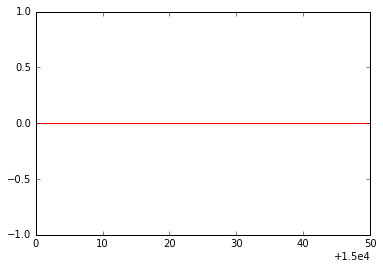

In [26]:
#HanEcho Phase Sweep

#import AWG 
import numpy as np
#import inst 

expSeq=Sequence()

#Phase Information
SiVBFreq=12.28*10**9
SiVFFreq=12.63*10**9
AmpB=1
AmpF=1#Currently SiV 7
SiVBPhaseX=Phase(SiVBFreq,AmpB,0)
SiVBPhaseY=Phase(SiVBFreq,AmpB,90)
SiVBPhaseMX=Phase(SiVBFreq,AmpB,225)
SiVFPhaseX=Phase(SiVFFreq,AmpF,0)
SiVFPhaseY=Phase(SiVFFreq,AmpF,90)
SiVFPhaseMX=Phase(SiVFFreq,AmpF,60)
piB= 26
piF= 56

baseFlags=['LOW','LOW','LOW','LOW']
pattern=[255,254]
step=[2,3]

baseWaitChunk=expSeq.appendWait(10,MetaChunk(expSeq.getNextID(),'Ch1Wait', 0,baseFlags,'INF'))
EPiB=expSeq.appendChunk(SiVBPhaseX,piB,0,MetaChunk(expSeq.getNextID(), 'EPiB',0))
EPiF=expSeq.appendChunk(SiVFPhaseX,piF,0,MetaChunk(expSeq.getNextID(), 'EPiF',0))




#Start Generating XY8 Sequences

#To Generate Phase Sweeps
ASet=np.linspace(0,360,73)
Tau1=1000
Tau2=1060
for i in np.arange(np.size(ASet)):

    doubleHan(expSeq,SiVBPhaseX,SiVBPhaseY,SiVBPhaseMX,SiVFPhaseX,SiVFPhaseY,SiVFPhaseMX,piB,piF,Tau1,Tau2,ASet[i],MetaChunk(expSeq.getNextID(),'Han_'+str(i+1)))
    pattern=np.concatenate((pattern,[i]),axis=0)
    step=np.concatenate((step,[4+i]),axis=0)
    
    
#Comment out these lines to remove printout 
expSeq.tabulate()
plt.figure()
expSeq.plotGroomedChunk(3)
expSeq.plotGroomedChunk(21)
expSeq.plotGroomedChunk(39)
#CheckPhase coherence of last pulse
plt.xlim((15000,15050))
#CheckPhase coherence of middle pulse
#plt.xlim((7500,7550))


    
#Uncomment all of these lines to actually load into AWG
    
instbox=Inst()
my_instrument=instbox.instrument
instbox.prepareforsequenceloading()
seqname='ExpSequence'
expSeq.loadSequence(instbox,seqname)

instbox.generateDJtable(seqname, pattern,step)
instbox.assignsequence(seqname)





Exception ignored in: <bound method Resource.__del__ of <'TCPIPInstrument'('TCPIP0::140.247.189.190::inst0::INSTR')>>
Traceback (most recent call last):
  File "C:\Users\NewTom\Anaconda3\lib\site-packages\pyvisa\resources\resource.py", line 114, in __del__
    self.close()
  File "C:\Users\NewTom\Anaconda3\lib\site-packages\pyvisa\resources\resource.py", line 253, in close
    self.visalib.close(self.session)
  File "C:\Users\NewTom\Anaconda3\lib\site-packages\pyvisa\ctwrapper\functions.py", line 394, in close
    return library.viClose(session)
  File "C:\Users\NewTom\Anaconda3\lib\site-packages\pyvisa\ctwrapper\highlevel.py", line 193, in _return_handler
    raise errors.VisaIOError(ret_value)
pyvisa.errors.VisaIOError: VI_ERROR_CLOSING_FAILED (-1073807338): The VISA driver failed to properly close the session or object reference. This might be due to an error freeing internal or OS resources, a failed network connection, or a lower-level driver or OS error.


(101000, 101100)

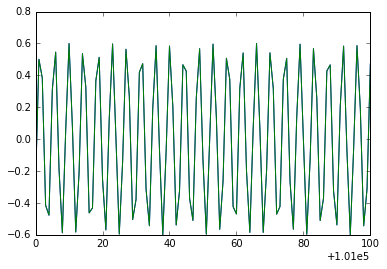

In [144]:
plt.figure()
expSeq.plotGroomedChunk(50)
expSeq.plotGroomedChunk(99)
plt.xlim([101000,101100])

In [31]:
instbox=Inst()
my_instrument=instbox.instrument
instbox.prepareforsequenceloading()

SOUR:FREQ 100000000
1

100.0000000000E+6



'100.0000000000E+6\n'